In [1]:
import sys
sys.path.append('./gym_dagsched')
sys.path.append('./gym_dagsched/envs')
from copy import copy

import gym
import numpy as np
from dataclasses import asdict

import gym_dagsched.envs
from gym_dagsched.args import args
from visualization import make_gantt

env = gym.make('dagsched-v0')

In [2]:
obs = env.reset()
done = False

while not done:    
    frontier_stages = obs.get_frontier_stages()
    avail_workers = obs.find_available_workers()
    
    if len(avail_workers) == 0 or len(frontier_stages) == 0:
        if len(avail_workers) == 0:
            print('no available workers')
        else:
            print('frontier is empty')
        action = {
            'job_id': args.n_jobs,
            'stage_id': args.max_stages,
            'worker_type_counts': np.zeros(args.n_worker_types)
        }
    else:
        for stage in frontier_stages:
            for worker in avail_workers:
                if worker.compatible_with(stage):
                    first_stage = stage
        
        stage_id = first_stage.id_
        job_id = first_stage.job_id
        
        avail_counts = obs.get_avail_worker_counts(args.n_worker_types)
        
        stage = obs.jobs[job_id].stages[stage_id]
        worker_types = stage.compatible_worker_types()
        
        n_workers = 0
        worker_type_counts = np.zeros(args.n_worker_types, dtype=int)
        for worker_type in worker_types:
            if n_workers == stage.n_remaining_tasks:
                break
            avail_count = avail_counts[worker_type]
            request_count = int(min(stage.n_remaining_tasks - n_workers, avail_count))
            worker_type_counts[worker_type] = request_count
            n_workers += request_count
        
        print(f'n_workers={n_workers}')

        action = {
            'job_id': job_id,
            'stage_id': stage_id,
            'worker_type_counts': worker_type_counts
        }
    
    print()
    prev_obs = copy(obs)
    obs, _, done, _ = env.step(action)

frontier is empty

invalid action
1.5010389131832902: job arrival
n_workers=2

1.501038908958435: nudge
n_workers=2

10.36647968711929: job arrival
n_workers=1

14.911957634185566: job arrival
no available workers

invalid action
22.110366821289062: task completion (0,7,0)
n_workers=1

22.110366821289062: task completion (0,7,1)
n_workers=1

29.96817398071289: task completion (0,6,0)
n_workers=1

29.96817398071289: task completion (0,6,1)
stage completion
n_workers=1

31.309568405151367: task completion (1,7,0)
n_workers=1

49.29997253417969: task completion (1,6,0)
n_workers=1

50.6413688659668: task completion (1,6,1)
n_workers=1

50.91126251220703: task completion (1,7,1)
stage completion
n_workers=0

invalid action
52.298944002668065: job arrival
n_workers=1

54.13291931152344: task completion (2,0,0)
stage completion
n_workers=1

60.234249114990234: task completion (2,1,0)
stage completion
job completion
n_workers=1

67.18500104847375: job arrival
no available workers

invalid act

In [12]:
env.observation_space.contains(asdict(prev_obs))

True

In [10]:
fig_gantt, df_gantt = make_gantt(prev_obs)
fig_gantt.show()

# store expected task duration for each different worker
# add priorities to jobs for weighted completion time
# job level parallelism
# objectives: Weighted tardiness, weighted completion time,  
# heuristics: FCFS, SJF, EDD, min-min/max-min

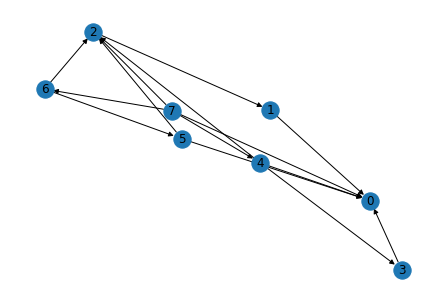

In [6]:
import networkx as nx
G = prev_obs.jobs[4].dag_to_nx()
nx.draw(G, with_labels=True)

In [16]:
prev_obs.jobs[5].stages[2].n_tasks

4